# 1. Read price and volume data

In [1]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

def read_data(filename):
    data = pd.read_pickle(filename)
    return data

# Read price and volume data
stocks_price = read_data('spy_stocks_price_2010_2020.bz2')
stocks_volume = read_data('spy_stocks_volume_2010_2020.bz2')

## Filter stocks with high turnover

In [2]:
# Filter the top 120 stocks
filtered_stocks = (stocks_price[:90] * stocks_volume[:90]
                   ).mean().sort_values(ascending=False).index[:120]

# Drop NaN values
filtered_stocks_prices = stocks_price[filtered_stocks].dropna()

filtered_stocks_prices.iloc[:5, :5]

,AAPL,BAC,C,GS,GOOGL
Date,,,,,
2009-12-31,26.06,13.35,30.03,145.17,310.30
2010-01-04,26.47,13.91,30.84,148.82,313.69
2010-01-05,26.51,14.37,32.02,151.45,312.31
2010-01-06,26.09,14.53,33.02,149.83,304.43
2010-01-07,26.04,15.01,33.11,152.76,297.35


# 2. Read income statement data

In [3]:
# Read quarterly income statement for the tickers in filtered stocks
quarterly_income_statement = pd.read_csv('quarterly_income_statement.csv')

quarterly_income_statement.head(2)

,Ticker,Report Date,Publish Date,Revenue,Net Income,Operating Income (Loss)
0,AAPL,2009-06-30,2009-07-21,9.734000e+09,1828000000,2632000000
1,AAPL,2009-09-30,2009-10-21,1.220700e+10,2532000000,3684000000


# 3. Calculate the fundamental factor

In [4]:
# Create dataframe with unique 'Publish Date'
fundamental_data = pd.DataFrame(index=quarterly_income_statement['Publish Date'].unique())

fundamental_data.head()

""
2009-07-21
2009-10-21
2010-01-25
2010-04-21
2010-07-21


In [5]:
# Calculate quarterly operating income growth
for sym in quarterly_income_statement.Ticker.unique():
    df = quarterly_income_statement.loc[quarterly_income_statement.Ticker == sym]
    df = df.set_index('Publish Date')
    df['operating_income_growth'] = 100 * \
        (df['Operating Income (Loss)']/df['Operating Income (Loss)'].shift(4)-1)
    fundamental_data[sym] = df['operating_income_growth']

 # Sort index of fundamental data
fundamental_data = fundamental_data.sort_index()

# Forward fill the quarterly data to missing values
fundamental_data = fundamental_data.fillna(method='ffill')

# Consider fundamental data dataframe from 2012 to mid 2019
fundamental_data = fundamental_data.loc['2012':'2019-06-30']

# Drop the columns with NaN values
fundamental_data = fundamental_data.dropna(axis=1).dropna()

# Convert index to datetime
fundamental_data.index = pd.to_datetime(fundamental_data.index)

# Print the dimensions of fundamental data dataframe
fundamental_data.shape

(866, 70)

In [6]:
# Select filtered_stock_prices data from 2012 to mid 2019 with tickers having fundamental data columns
filtered_stocks_prices = filtered_stocks_prices.loc['2012':'2019-06-30',
                                                    fundamental_data.columns]
# Drop the columns with NaN values
filtered_stocks_prices = filtered_stocks_prices.dropna(axis=1)

filtered_stocks_prices.shape

(1884, 70)

In [7]:
# Create a dataframe 'dates'
dates = pd.DataFrame(index=filtered_stocks_prices.index)

# Merge 'fundamental_data' dataframe with 'dates' and forward fill the missing values
fundamental_data = fundamental_data.merge(
    dates, right_index=True, left_index=True, how='right')

fundamental_data = fundamental_data.fillna(method='ffill')
fundamental_data = fundamental_data.dropna()

fundamental_data.shape

(1879, 70)

In [8]:
# Keep the fundamental_data index
filtered_stocks_prices = filtered_stocks_prices.loc[fundamental_data.index, :]

# filtered_stocks_prices.shape
filtered_stocks_prices.shape

(1879, 70)

# 4. Backtest CSMOM strategy

## 4.1 Fundamental momentum strategy

In [9]:
def fundamental_momentum(prices, fundamental_data, hold_days):

    # Calculate the stock returns over the the given holding period
    hold_returns = prices.pct_change(hold_days).shift(-hold_days)

    # Rank the stock returns based on the operating income
    fundamental_rank = fundamental_data.rank(axis=1)
    n = len(fundamental_rank.columns)

    # Generate signal "1" for rank > 90, "-1" for rank < 10
    def signal(rank):
        signal = np.where(rank > n*9/10, 1, np.nan)
        signal = np.where(rank < n*1/10, -1, signal)
        return signal

    # Apply the signal function to fundamental_rank and generate a new dataframe trading_signal
    trading_signal = fundamental_rank.apply(signal, axis=0)
    return hold_returns, trading_signal

# --------------------------------------------------------------------------------------------


def calculate_performance(hold_returns, trading_signal, hold_days):

    # Calculate the stock returns with hold_returns * trading_signal after selecting the rows without NaNs from both the dataframes
    stocks_returns = hold_returns * trading_signal
    stocks_returns = stocks_returns[::hold_days]
    trading_signal = trading_signal[::hold_days]
    trading_signal = trading_signal.replace(np.nan, 0)

    # Calculate the trading cost when you square off the position and calculate the net stock_returns
    cost = (0.001 * np.abs(trading_signal - trading_signal.shift(1)))
    stocks_returns = stocks_returns - cost

    # Calculate the portfolio returns
    portfolio_returns = stocks_returns.mean(axis=1)
    cum_rets = (portfolio_returns+1).cumprod().dropna()

# --------------------------------------------------------------------------------------------------

    # Calculate portfolio returns
    total_portfolio_returns = (cum_rets.iloc[-1]-1)*100
    print("Portfolio Returns: %.2f" % total_portfolio_returns)

    # Calculate sharpe ratio
    sharpe = np.mean(portfolio_returns) / \
        np.std(portfolio_returns)*((252/hold_days)**0.5)
    print('Sharpe Ratio: %.2f' % sharpe)

    # Plot cumulative portfolio returns
    fig = plt.figure(figsize=(16, 7))
    sub = fig.add_subplot(1, 2, 1)
    cum_rets.plot()
    sub.set_ylabel('Strategy Returns', fontsize=12)
    sub.set_ylabel('Date', fontsize=12)

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = ((cum_rets)/running_max - 1)

    # Plot drawdown
    sub = fig.add_subplot(1, 2, 2)
    drawdown.plot(color='r')
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    sub.set_ylabel('Returns', fontsize=12)
    plt.show()

Portfolio Returns: 57.38
Sharpe Ratio: 0.77


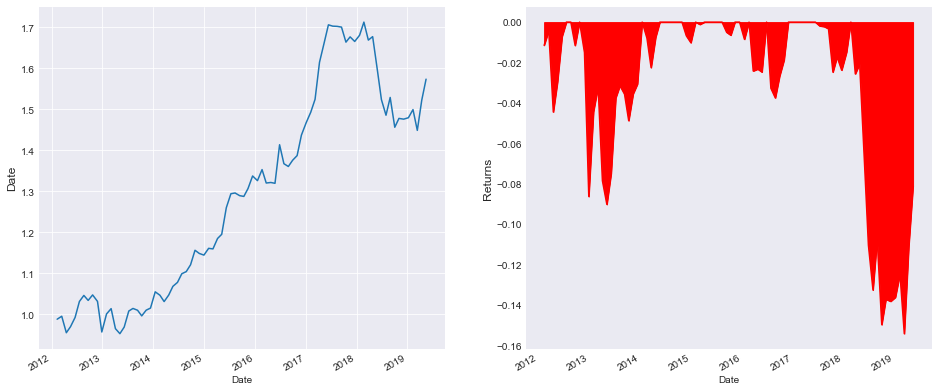

In [10]:
# Call the function strategy with below inputs
hold_days = 22

hold_returns, trading_signal = fundamental_momentum(
    filtered_stocks_prices, fundamental_data, hold_days)

calculate_performance(hold_returns, trading_signal, hold_days)

## 4.2 Combined momentum strategy

In [11]:
def fundamental_price_momentum(prices, fundamental_data, hold_days, lookback_days, skip_days):

    hold_returns = prices.pct_change(hold_days).shift(-hold_days)
    # Rank the stocks based on the operating income growth
    fundamental_rank = fundamental_data.rank(axis=1)

    # Calculate stock returns over the given lookback period with skip_days
    lookback_returns = filtered_stocks_prices.pct_change(
        lookback_days).shift(skip_days)
    # Rank the stocks based on the lookback returns
    lookback_rank = lookback_returns.rank(axis=1)

    # Calculate the final rank with weight to calculated lookback and fundamental ranks
    final_rank = (0.5*lookback_rank+0.5*fundamental_rank).rank(axis=1)

    n = len(fundamental_rank.columns)

    def signal(rank):
        signal = np.where(rank > n*9/10, 1, np.nan)
        signal = np.where(rank < n/10, -1, signal)
        return signal

    # Generate a new dataframe trading_signal with final rank
    trading_signal = final_rank.apply(signal, axis=0)
    return hold_returns, trading_signal

Portfolio Returns: 87.48
Sharpe Ratio: 1.13


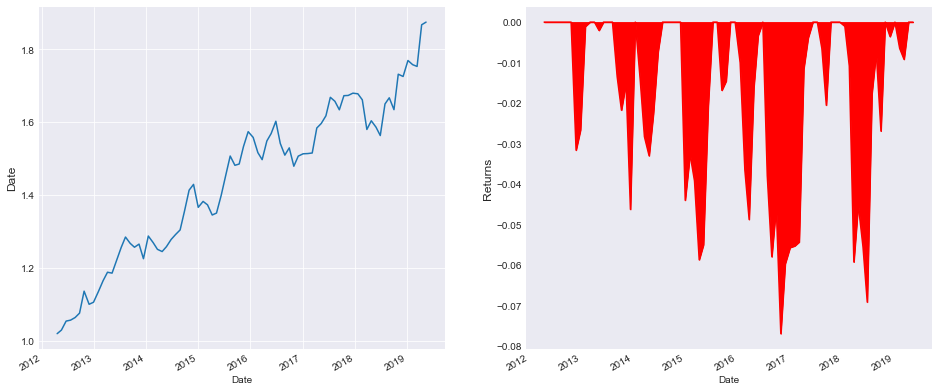

In [12]:
# Call the function strategy with below inputs
hold_days = 22
lookback_days = 45
skip_days = 5

hold_returns, trading_signal = fundamental_price_momentum(
    filtered_stocks_prices, fundamental_data, hold_days, lookback_days, skip_days)

calculate_performance(hold_returns, trading_signal, hold_days)